## Assignment 5
* DEL CARPIO CUENCA, GABRIEL SEBASTIAN

* JAIME MARTINEZ, KEVIN OSWALDO

* QUISPE ROBLADILLO, ALMENDRA VALERIA

### Part 1: Heterogeneous treatment effects using causal trees and forests

For this part, we will be using experimental data for computing heterogeneous effects through causal trees and forests. For all exercises, the predictors $ X $ are all variables that are not the outcome $Y$ or the treatment 
$ D$.

In [36]:
#!pip install multiprocess

In [37]:
# !pip install econml

In [38]:
!git clone https://github.com/maxhuppertz/hdmpy.git

fatal: destination path 'hdmpy' already exists and is not an empty directory.


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import hdmpy
import patsy

from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression, Ridge, Lasso, LogisticRegressionCV, LogisticRegression, ElasticNet
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, train_test_split

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, clone

from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import CausalForestDML
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.simplefilter('ignore')
np.random.seed(123) 

1.1. Load the data (1 points).

In [40]:
data_part1 = pd.read_csv('../data/experimental/experimental_control.csv')
data_part1

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
0,1,37,11,1,0,1,1,0.000000,0.000000,9930.045898
1,1,22,9,0,1,0,1,0.000000,0.000000,3595.894043
2,1,30,12,1,0,0,0,0.000000,0.000000,24909.449219
3,1,27,11,1,0,0,1,0.000000,0.000000,7506.145996
4,1,33,8,1,0,0,1,0.000000,0.000000,289.789886
...,...,...,...,...,...,...,...,...,...,...
440,0,21,9,1,0,0,1,31886.429688,12357.219727,0.000000
441,0,28,11,1,0,0,1,17491.449219,13371.250000,0.000000
442,0,29,9,0,1,0,1,9594.307617,16341.160156,16900.300781
443,0,25,9,1,0,1,1,24731.619141,16946.630859,7343.963867


In [41]:
list(data_part1.columns)

['treat',
 'age',
 'educ',
 'black',
 'hisp',
 'marr',
 'nodegree',
 're74',
 're75',
 're78']

In [42]:
print(data_part1.isnull().sum())
# No missings

treat       0
age         0
educ        0
black       0
hisp        0
marr        0
nodegree    0
re74        0
re75        0
re78        0
dtype: int64


In [43]:
data_part1["treat"].value_counts()
# We have 185 treated y 260 controls

treat
0    260
1    185
Name: count, dtype: int64

In [44]:
# Variables: black, marr, nodegree
variables = ['black', 'marr', 'nodegree']

# Summary stats para cada grupo
for group in [0, 1]:
    stats = data_part1[data_part1['treat'] == group][variables].agg(['mean', 'sum', 'count'])
    if group == 1:
        print("\nGrupo tratado (treat=1):")
    else:
        print("\nGrupo control (treat=0):")
    print(stats)


Grupo control (treat=0):
            black        marr    nodegree
mean     0.826923    0.153846    0.834615
sum    215.000000   40.000000  217.000000
count  260.000000  260.000000  260.000000

Grupo tratado (treat=1):
            black        marr    nodegree
mean     0.843243    0.189189    0.708108
sum    156.000000   35.000000  131.000000
count  185.000000  185.000000  185.000000


In [45]:
# Control
for var in variables:
    mean_value = data_part1[data_part1['treat'] == 0][var].mean()
    print(f"People with '{var}' in the control group is {mean_value:.2%}")

# Treated
for var in variables:
    mean_value = data_part1[data_part1['treat'] == 1][var].mean()
    print(f"People with '{var}' in the control group is {mean_value:.2%}")

# As can be seen, there are no noticeable differences between the control group and the treated group. 

People with 'black' in the control group is 82.69%
People with 'marr' in the control group is 15.38%
People with 'nodegree' in the control group is 83.46%
People with 'black' in the control group is 84.32%
People with 'marr' in the control group is 18.92%
People with 'nodegree' in the control group is 70.81%


1.2. Find the ATE (1.5 points). With re78 as the outcome variable of interest, find the Average Treatment Effect of participation in the program. Specifically, you should find it by calculating the difference between the means of the treatment group and the control group (the Simple Difference of Means or SDM). What can you say about the program?

In [46]:
y = data_part1["re78"] # outcome variable of interest
d = data_part1["treat"] #In the National Supported Work Demonstration Job Training Program
X = data_part1[data_part1.columns[~data_part1.columns.isin(['treat','re78'])]]

In [47]:
# OJO: re78 = Real earnings 1978 (in thousands of dollars)
# TREATMENT
mean_treated = data_part1[data_part1["treat"] == 1]["re78"].mean()

# CONTROL
mean_control = data_part1[data_part1["treat"] == 0]["re78"].mean()

# ATE: 
ate = mean_treated - mean_control

print(f"Mean re78 for the treated group: {mean_treated:.2f}")
print(f"Mean re78 for the control group: {mean_control:.2f}")
print(f"Average Treatment Effect (ATE): {ate:.2f}")

# OJO: its the same result 

Mean re78 for the treated group: 6349.14
Mean re78 for the control group: 4554.80
Average Treatment Effect (ATE): 1794.34


In [48]:
# OTHER WAY TO CALCULATE THE ATE
smf.ols('y ~ d', data_part1).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4554.8011,408.046,11.162,0.000,3752.855,5356.747
d,1794.3424,632.853,2.835,0.005,550.574,3038.110


The treatment has an average effect of : 1794.34

The ATE of 1794.34 indicates that, on average, people who participated in the job training program (treatment) had  1,794.34 more in real income in 1978 compared to those who did not participate (control group).

1.3. Heterogeneous effects with causal trees (3 points). Use causal trees like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to create the auxiliary variable 
Y
∗
 and fit a decision tree regressor. Report the splits the tree finds and interpret them.

OJO: we had defined the variables before in 1.2

y = re78 , outcome variable of interest

d = treat , In the National Supported Work Demonstration Job Training Program

X = variables

In [49]:
# CAUSAL TREE
np.random.seed(0)
tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=3)
tree_model = tree_model.fit(Y=data_part1['re78'], X=X, T=data_part1['treat'])

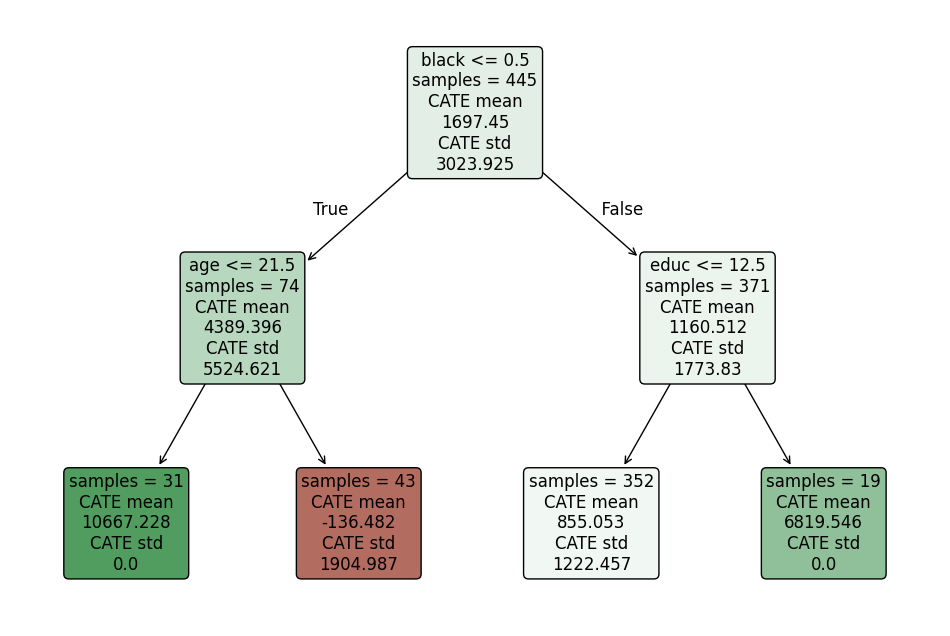

In [50]:
# Graphic
intrp = SingleTreeCateInterpreter(max_depth=2).interpret(tree_model, X)
plt.figure(figsize=(12, 8))
intrp.plot(feature_names=X.columns.tolist(), fontsize=12)
plt.show()

Interpretation:

The causal tree shows how the impact of the job training program varies across subgroups. Non-black individuals, particularly younger ones, experience the highest positive effects, while some subgroups, like older non-black individuals, may see negative or negligible impacts. Among black individuals, those with higher education benefit the most from the program, while those with lower education see moderate but positive effects. Variability in the program's impact is notable in some groups, highlighting the importance of targeting interventions effectively.

1.4. Heterogeneous effects with causal forests (3 points). Use causal forests like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to use the auxiliary variable 
Y
∗
 computed in the previous exercise and fit a random forest regressor. Report the importance of the prediction variables.

In [51]:
# FOREST CAUSAL
np.random.seed(1)
forest_model = CausalForestDML(max_depth=3)
forest_model = forest_model.fit(Y=y,X=X,T=d)

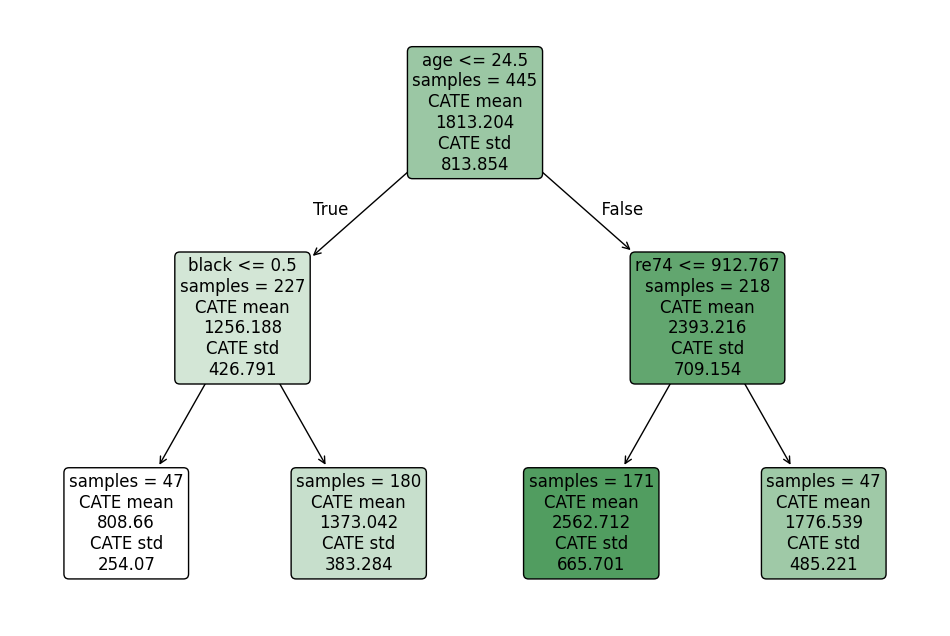

In [52]:
# Graphic
intrp = SingleTreeCateInterpreter(max_depth=2).interpret(forest_model, X)

plt.figure(figsize=(12, 8))
intrp.plot(feature_names=X.columns.tolist(), fontsize=12)
plt.show()

INTERPRETATION:The causal forest highlights the heterogeneity in the program's impact across subgroups. Younger individuals (age ≤ 24.5) tend to experience lower effects compared to those with higher prior earnings (re74 > 912.767). Non-black participants show slightly lower average effects compared to their counterparts. This analysis suggests that age and prior earnings are critical factors in determining the effectiveness of the program.

In [53]:
# Relevance of the variables: 
pd.DataFrame({"variable": X.columns.tolist(), "importance": forest_model.feature_importances()})

,variable,importance
0,age,0.262397
1,educ,0.175974
2,black,0.102413
3,hisp,0.022443
4,marr,0.019011
5,nodegree,0.020481
6,re74,0.183396
7,re75,0.213885


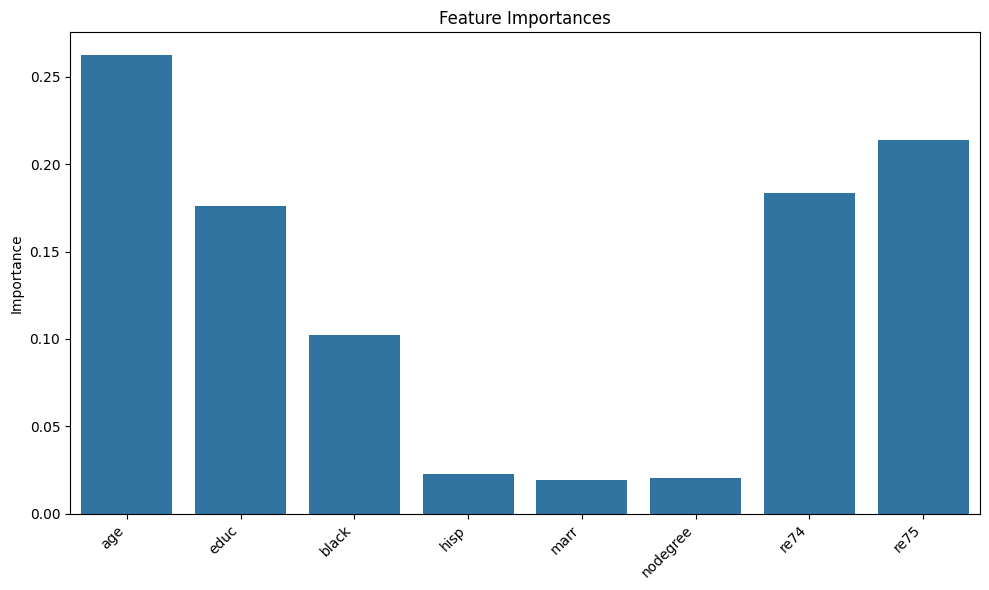

In [54]:
# Crear una lista con los nombres de las características
feature_names = X.columns.tolist()

# Crear el gráfico de barras para las importancias de las características
fig, ax = plt.subplots(figsize=(10, 6))  # Puedes ajustar el tamaño del gráfico según sea necesario
sns.barplot(x=feature_names, y=forest_model.feature_importances_, color='C0', ax=ax).set(
    title='Feature Importances', ylabel='Importance')

# Rotar las etiquetas de los ejes x para mejorar la legibilidad
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Mostrar el gráfico
plt.tight_layout()  # Ajusta el layout para que las etiquetas no se corten
plt.show()


The variables that have more importance are: age, re75, re74 and educ

1.5. Plot heterogeneous effects (1.5 points). Plot how the predicted treatment effect changes depending on a variable of your choice.

In [55]:
# predicted_effects
data_part1['predicted_effects'] = forest_model.effect(X)
data_part1

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,predicted_effects
0,1,37,11,1,0,1,1,0.000000,0.000000,9930.045898,2932.202109
1,1,22,9,0,1,0,1,0.000000,0.000000,3595.894043,774.258917
2,1,30,12,1,0,0,0,0.000000,0.000000,24909.449219,3737.445234
3,1,27,11,1,0,0,1,0.000000,0.000000,7506.145996,2397.850417
4,1,33,8,1,0,0,1,0.000000,0.000000,289.789886,2393.414386
...,...,...,...,...,...,...,...,...,...,...,...
440,0,21,9,1,0,0,1,31886.429688,12357.219727,0.000000,1809.647295
441,0,28,11,1,0,0,1,17491.449219,13371.250000,0.000000,2230.497726
442,0,29,9,0,1,0,1,9594.307617,16341.160156,16900.300781,778.112419
443,0,25,9,1,0,1,1,24731.619141,16946.630859,7343.963867,2277.266569


In [56]:
# Var: age, re74, re75)
data_part1['age_bins'] = (data_part1['age'] // 5) * 5
data_part1['age_bins'] = np.where(data_part1['age_bins'] == 15, 17, data_part1['age_bins'])  # Reemplace for the min value
data_part1['re74_bins'] = (data_part1['re74'] // 500) * 500
data_part1['re75_bins'] = (data_part1['re75'] // 500) * 500

# Predicted effects:
predicted_effects_age = data_part1.groupby('age_bins')['predicted_effects'].mean().reset_index()
predicted_effects_re74 = data_part1.groupby('re74_bins')['predicted_effects'].mean().reset_index()
predicted_effects_educ = data_part1.groupby('educ')['predicted_effects'].mean().reset_index()
predicted_effects_re75 = data_part1.groupby('re75_bins')['predicted_effects'].mean().reset_index()


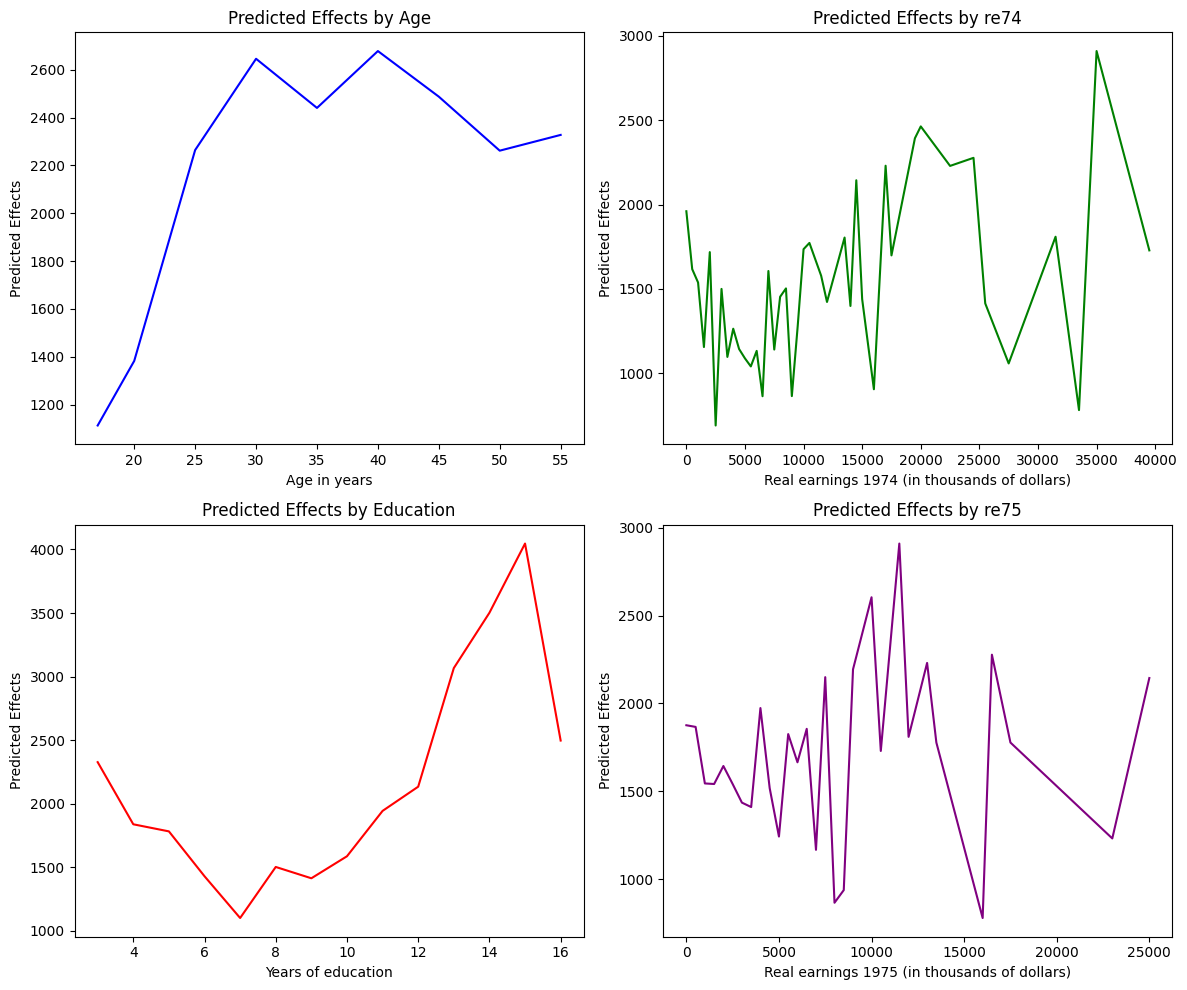

In [57]:
#GRAPHICS:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()  # Asegurar acceso fácil a cada subplot

# AGE
axs[0].plot(predicted_effects_age['age_bins'], predicted_effects_age['predicted_effects'], color='blue')
axs[0].set_title("Predicted Effects by Age")
axs[0].set_xlabel("Age in years")
axs[0].set_ylabel("Predicted Effects")

# re74
axs[1].plot(predicted_effects_re74['re74_bins'], predicted_effects_re74['predicted_effects'], color='green')
axs[1].set_title("Predicted Effects by re74")
axs[1].set_xlabel("Real earnings 1974 (in thousands of dollars)")
axs[1].set_ylabel("Predicted Effects")

# EDUCATION
axs[2].plot(predicted_effects_educ['educ'], predicted_effects_educ['predicted_effects'], color='red')
axs[2].set_title("Predicted Effects by Education")
axs[2].set_xlabel("Years of education")
axs[2].set_ylabel("Predicted Effects")

# Re75
axs[3].plot(predicted_effects_re75['re75_bins'], predicted_effects_re75['predicted_effects'], color='purple')
axs[3].set_title("Predicted Effects by re75")
axs[3].set_xlabel("Real earnings 1975 (in thousands of dollars)")
axs[3].set_ylabel("Predicted Effects")

plt.tight_layout()
plt.show()


### Part 2: Double/Debiased machine learning in observational data

In this part, we will be using observational data for computing the average treatment effect of the same program as in Part 1. This data is constructed by taking the treatment group from the same dataset as in Part 1, but constructing the control group from a different dataset; that is, the entirety of the control is comprised of observations from the Current Population Survey. Therefor, we may not have comparable treatment and control groups. To tackle this issue, we can use Double/Debiased machine learning.



2.1. Load the data (1 points).

In [58]:
data_part2 = pd.read_csv('../data/observational/biased_control.csv')
data_part2

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,agesq,agecube,educsq,u74,u75,interaction1,re74sq,re75sq
0,0,45,11,0,0,1,1,21.516670,25.243551,25.564670,2025,91125,121,0,0,236.683369,462.967085,637.236856
1,0,21,14,0,0,0,0,3.175971,5.852565,13.496080,441,9261,196,0,0,44.463593,10.086791,34.252516
2,0,38,12,0,0,1,0,23.039020,25.130760,25.564670,1444,54872,144,0,0,276.468234,530.796421,631.555086
3,0,48,6,0,0,1,1,24.994369,25.243551,25.564670,2304,110592,36,0,0,149.966215,624.718489,637.236856
4,0,18,8,0,0,1,1,1.669295,10.727610,9.860869,324,5832,64,0,0,13.354360,2.786546,115.081624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16172,1,33,12,1,0,1,0,20.279949,10.941350,15.952600,1089,35937,144,0,0,243.359391,411.276340,119.713131
16173,1,25,14,1,0,1,0,35.040070,11.536570,36.646949,625,15625,196,0,0,490.560984,1227.806528,133.092455
16174,1,35,9,1,0,1,1,13.602430,13.830640,12.803970,1225,42875,81,0,0,122.421867,185.026093,191.286593
16175,1,35,8,1,0,1,1,13.732070,17.976150,3.786628,1225,42875,64,0,0,109.856562,188.569755,323.141983


In [59]:
list(data_part2.columns)

['treat',
 'age',
 'educ',
 'black',
 'hisp',
 'marr',
 'nodegree',
 're74',
 're75',
 're78',
 'agesq',
 'agecube',
 'educsq',
 'u74',
 'u75',
 'interaction1',
 're74sq',
 're75sq']

In [60]:
print(data_part2.isnull().sum())
# NO missings

treat           0
age             0
educ            0
black           0
hisp            0
marr            0
nodegree        0
re74            0
re75            0
re78            0
agesq           0
agecube         0
educsq          0
u74             0
u75             0
interaction1    0
re74sq          0
re75sq          0
dtype: int64


In [61]:
# NORMALIZATION 
numeric_columns = ['age', 'educ', 're74', 're75', 're78', 'agesq', 'agecube', 'educsq', 'interaction1', 're74sq', 're75sq']
x_numeric = data_part2[numeric_columns]

# StandardScaler
x_numeric = StandardScaler().fit_transform(x_numeric)
x_numeric = pd.DataFrame(x_numeric, columns=numeric_columns)
data_part2[numeric_columns] = x_numeric
print(data_part2.head())


   treat       age      educ  black  hisp  marr  nodegree      re74      re75  \
0      0  1.074602 -0.351574      0     0     1         1  0.794377  1.259684   
1      0 -1.100066  0.694482      0     0     0         0 -1.113565 -0.822476   
2      0  0.440324 -0.002888      0     0     1         0  0.952744  1.247573   
3      0  1.346436 -2.095000      0     0     1         1  1.156154  1.259684   
4      0 -1.371899 -1.397629      0     0     1         1 -1.270301 -0.299004   

       re78     agesq   agecube    educsq  u74  u75  interaction1    re74sq  \
0  1.118346  1.027409  0.935718 -0.468605    0    0      0.518831  0.682810   
1 -0.129608 -0.994453 -0.882222  0.649826    0    0     -0.964554 -1.055486   
2  1.118346  0.285805  0.130654 -0.125619    0    0      0.825856  0.943161   
3  1.118346  1.383533  1.368018 -1.736159    0    0     -0.150376  1.303663   
4 -0.505508 -1.143795 -0.958369 -1.318612    0    0     -1.204628 -1.083506   

     re75sq  
0  1.488962  
1 -0.95125

2.2. Group comparisons (1.5 points). For the treatment and control group separately, report summary statistics of three variables of your choice. Can you spot any big differences between the treatment and control groups?

In [62]:
data_part2["treat"].value_counts()
# We hava 185 treated y 15992 controls

treat
0    15992
1      185
Name: count, dtype: int64

In [63]:
# Variables: black, marr, nodegree
variables = ['black', 'marr', 'nodegree']

# Summary stats para cada grupo
for group in [0, 1]:
    stats = data_part2[data_part2['treat'] == group][variables].agg(['mean', 'sum', 'count'])
    if group == 1:
        print("\nGrupo tratado (treat=1):")
    else:
        print("\nGrupo control (treat=0):")
    print(stats)



Grupo control (treat=0):
              black          marr      nodegree
mean       0.073537      0.711731      0.295835
sum     1176.000000  11382.000000   4731.000000
count  15992.000000  15992.000000  15992.000000

Grupo tratado (treat=1):
            black        marr    nodegree
mean     0.843243    0.189189    0.708108
sum    156.000000   35.000000  131.000000
count  185.000000  185.000000  185.000000


In [64]:
# Control
for var in variables:
    mean_value = data_part2[data_part2['treat'] == 0][var].mean()
    print(f"People with '{var}' in the control group is {mean_value:.2%}")

# Treated
for var in variables:
    mean_value = data_part2[data_part2['treat'] == 1][var].mean()
    print(f"People with '{var}' in the control group is {mean_value:.2%}")


People with 'black' in the control group is 7.35%
People with 'marr' in the control group is 71.17%
People with 'nodegree' in the control group is 29.58%
People with 'black' in the control group is 84.32%
People with 'marr' in the control group is 18.92%
People with 'nodegree' in the control group is 70.81%


As can be seen, there are noticeable differences between the control group and the treated group. 

- In the control group, the percentage of Black individuals is only 7.35%, while in the treatment group, this percentage jumps significantly to 84.32%. 
- Additionally, the proportion of married individuals in the control group is 71.17%, compared to just 18.92% in the treatment group. 
- Lastly, the proportion of individuals without a degree (nodegree) is 29.58% in the control group, but much higher at 70.81% in the treatment group. 

These differences suggest a distinct demographic composition between the two groups.

2.3. Compute the SMD (1.5 points). Find the simple difference of means, which we can use as a naive estimate of the ATE. How does the result in this case compare to the result in point 1.2.?

In [65]:
y = data_part2["re78"] # outcome variable of interest
d = data_part2["treat"] #In the National Supported Work Demonstration Job Training Program
x = data_part2[data_part2.columns[~data_part2.columns.isin(['treat','re78'])]]

In [66]:
# simple difference of means
# OJO: re78 = Real earnings 1978 (in thousands of dollars)
# TREATED
mean_treated = data_part2[data_part2["treat"] == 1]["re78"].mean()
# CONTROL
mean_control = data_part2[data_part2["treat"] == 0]["re78"].mean()

# ATE: 
ate = mean_treated - mean_control

print(f"Mean re78 for the treated group: {mean_treated:.2f}")
print(f"Mean re78 for the control group: {mean_control:.2f}")
print(f"Average Treatment Effect (ATE): {ate:.2f}")


Mean re78 for the treated group: -0.87
Mean re78 for the control group: 0.01
Average Treatment Effect (ATE): -0.88


How does the result in this case compare to the result in point 1.2.?

The result in 1.2 is that the ATE was 1794 , and now  is -0.88. We have a big difference here because we had normalize the data for the part 2. A part from this the sing is different. This difference is explicated by the fact that the dataset is different, in this case we have a disproportioned groups of control and treatment.

In [67]:
#extra:
# NORMALIZATION of the dataset from part 1
numeric_columns = ['age', 'educ', 're74', 're75', 're78']
x_numeric = data_part1[numeric_columns]
# StandardScaler
x_numeric = StandardScaler().fit_transform(x_numeric)
x_numeric = pd.DataFrame(x_numeric, columns=numeric_columns)
data_part1[numeric_columns] = x_numeric

#  ATE of the first dataset normalized
# OJO: re78 = Real earnings 1978 (in thousands of dollars)
# TREATMENT
mean_treated = data_part1[data_part1["treat"] == 1]["re78"].mean()

# CONTROL
mean_control = data_part1[data_part1["treat"] == 0]["re78"].mean()

# ATE: 
ate = mean_treated - mean_control
print(f"Average Treatment Effect (ATE): {ate:.2f}")


Average Treatment Effect (ATE): 0.27


Now we have both dataset normalized and still have a big difference between the ATE's. For the first the ate is 0.27 and for the second it's -0.88. This difference is explicated by the fact that the dataset is different, in the second case we have a great disproportion between groups of control and treatment.

2.4. Using DML (6 points). Use the DML procedure as we saw in the Lab, in order to find a better estimate of the ATE. You may use the doubleML packages for Python and R, but this package does not exist for Julia, so you will have to build your own procedure like we saw in class. You will be rewarded extra points for using more than one method for predictions. At the end, report the treatment effect you found, as well as the MSE for 
D
 and 
Y
 achieved by the method(s) you used.

In [68]:
def dml(X, D, y, modely, modeld, *, nfolds, classifier=False, time = None, clu = None, cluster = True):
    '''
    DML for the Partially Linear Model setting with cross-fitting

    Input
    -----
    X: the controls
    D: the treatment
    y: the outcome
    modely: the ML model for predicting the outcome y
    modeld: the ML model for predicting the treatment D
    nfolds: the number of folds in cross-fitting
    classifier: bool, whether the modeld is a classifier or a regressor

    time: array of time indices, eg [0,1,...,T-1,0,1,...,T-1,...,0,1,...,T-1]
    clu: array of cluster indices, eg [1073, 1073, 1073, ..., 5055, 5055, 5055, 5055]
    cluster: bool, whether to use clustered standard errors

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the treatment D
    resy: the outcome residuals
    resD: the treatment residuals
    epsilon: the final residual-on-residual OLS regression residual
    '''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123) # shuffled k-folds
    yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1) # out-of-fold predictions for y
    # out-of-fold predictions for D
    # use predict or predict_proba dependent on classifier or regressor for D
    if classifier:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    else:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1)
    # calculate outcome and treatment residuals
    resy = y - yhat
    resD = D - Dhat

    if cluster:
      # final stage ols clustered
      dml_data = pd.concat([clu, pd.Series(time), pd.Series(resy, name = 'resy'), pd.Series(resD, name = 'resD')], axis=1)

    else:
      # final stage ols nonclustered
      dml_data = pd.concat([pd.Series(resy, name = 'resy'), pd.Series(resD, name = 'resD')], axis=1)

    if cluster:
      # clustered standard errors
      ols_mod = smf.ols(formula = 'resy ~ 1 + resD', data = dml_data).fit(cov_type='cluster', cov_kwds={"groups": dml_data['CountyCode']})

    else:
      # regular ols
      ols_mod = smf.ols(formula = 'resy ~ 1 + resD', data = dml_data).fit()

    point = ols_mod.params[1]
    stderr = ols_mod.bse[1]
    epsilon = ols_mod.resid

    return point, stderr, yhat, Dhat, resy, resD, epsilon
     

In [69]:
def summary(point, stderr, yhat, Dhat, resy, resD, epsilon, X, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point, # point estimate
                         'stderr': stderr, # standard error
                         #'lower': point - 1.96*stderr, # lower end of 95% confidence interval
                         #'upper': point + 1.96*stderr, # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)), # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2)) # RMSE of model that predicts treatment D
                         }, index=[name])

In [70]:
class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return np.array(X) @ np.array(self.rlasso_.est['beta']).flatten() + np.array(self.rlasso_.est['intercept'])

lasso_model = lambda: RLasso(post=False)
     

# DML with OLS:
modely = make_pipeline(StandardScaler(), LinearRegression())
modeld = make_pipeline(StandardScaler(), LinearRegression())
result_OLS = dml(x,d,y, modely, modeld, nfolds=10, classifier=False, cluster = False)
table_OLS = summary(*result_OLS, x,d,y, name = 'OLS')

# DML with RLasso:
modely = make_pipeline(StandardScaler(), RLasso(post=False))
modeld = make_pipeline(StandardScaler(), RLasso(post=False))
result_RLasso = dml(x,d,y, modely, modeld, nfolds=10, classifier=False, cluster = False)
table_RLasso = summary(*result_RLasso, x,d,y, name = 'Lasso')


# DML with Random Forests
modely = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123))
modeld = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123))
result_RF = dml(x,d,y, modely, modeld, nfolds=10, classifier=False, cluster = False)
table_RF = summary(*result_RF, x,d,y, name = 'RF')

# DML with Mix:
modely = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123))
modeld = make_pipeline(StandardScaler(), RLasso(post=False))
result_mix = dml(x,d,y, modely, modeld, nfolds=10, classifier=False, cluster = False)
table_mix = summary(*result_mix, x,d,y, name = 'RF/Lasso Mix')
    
# More models:

# DML with Elastic Net
modely = make_pipeline(StandardScaler(), ElasticNetCV(cv=5, l1_ratio=0.5))
modeld = make_pipeline(StandardScaler(), ElasticNetCV(cv=5, l1_ratio=0.5))
result_EN = dml(x, d, y, modely, modeld, nfolds=10, classifier=False, cluster=False)
table_EN = summary(*result_EN, x, d, y, name='Elastic Net')

# DML with Support Vector Machines (SVM)
modely = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))
modeld = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))
result_SVM = dml(x, d, y, modely, modeld, nfolds=10, classifier=False, cluster=False)
table_SVM = summary(*result_SVM, x, d, y, name='SVM')
# DML with Gradient Boosting Machines (GBM)
modely = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=123))
modeld = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=123))
result_GBM = dml(x, d, y, modely, modeld, nfolds=10, classifier=False, cluster=False)
table_GBM = summary(*result_GBM, x, d, y, name='GBM')
# RESULTS
table = pd.concat([table_OLS, table_RLasso, table_RF, table_mix, table_EN, table_SVM, table_GBM], axis=0)
print(table)

              estimate    stderr    rmse y    rmse D
OLS           0.166871  0.057527  0.722554  0.098733
Lasso         0.112584  0.057073  0.723822  0.099707
RF            0.091778  0.068914  0.739324  0.084350
RF/Lasso Mix  0.098168  0.058297  0.739324  0.099707
Elastic Net   0.115349  0.053446  0.722901  0.106335
SVM           0.174383  0.061057  0.742843  0.106290
GBM           0.098293  0.067187  0.721296  0.084407


#### Interpretation of Results (Main Models)

Among the primary models (OLS, RLasso, Random Forest, and the Mix model), OLS and Elastic Net offered the most reliable estimates of treatment effects, with Elastic Net achieving the lowest standard error, indicating greater precision in the estimation. The Mix model, combining Random Forest and RLasso, balanced between accuracy and model complexity, showing strong predictive performance for both the treatment and outcome variables. Random Forest showed the highest RMSE for the outcome variable (y), suggesting it was less precise in capturing the variability of the outcome compared to the other methods.

#### Additional Models (Elastic Net, SVM, GBM)

The Elastic Net model was the most stable, achieving the lowest RMSE for both y and D, indicating that it provided the best fit overall. SVM, although it provided the highest estimated treatment effect, had a larger RMSE for D, indicating higher variability in the treatment model. GBM performed similarly to the other models, providing a balanced treatment effect with moderate RMSE for both the outcome and treatment.